In [2]:
import numpy as np
import matplotlib.pyplot as plt

from compressai.zoo import models
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio

import torch
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/private/home/pfz/miniconda3/envs/img/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/private/home/pfz/miniconda3/envs/img/lib/python3.12/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


In [7]:
models

{'bmshj2018-factorized': <function compressai.zoo.image.bmshj2018_factorized(quality, metric='mse', pretrained=False, progress=True, **kwargs)>,
 'bmshj2018-factorized-relu': <function compressai.zoo.image.bmshj2018_factorized_relu(quality, metric='mse', pretrained=False, progress=True, **kwargs)>,
 'bmshj2018-hyperprior': <function compressai.zoo.image.bmshj2018_hyperprior(quality, metric='mse', pretrained=False, progress=True, **kwargs)>,
 'mbt2018-mean': <function compressai.zoo.image.mbt2018_mean(quality, metric='mse', pretrained=False, progress=True, **kwargs)>,
 'mbt2018': <function compressai.zoo.image.mbt2018(quality, metric='mse', pretrained=False, progress=True, **kwargs)>,
 'cheng2020-anchor': <function compressai.zoo.image.cheng2020_anchor(quality, metric='mse', pretrained=False, progress=True, **kwargs)>,
 'cheng2020-attn': <function compressai.zoo.image.cheng2020_attn(quality, metric='mse', pretrained=False, progress=True, **kwargs)>,
 'bmshj2018-hyperprior-vbr': <functio

In [3]:
# Load a pre-trained model (options include: 'bmshj2018-factorized', 'mbt2018-mean', 
# 'cheng2020-anchor', 'mbt2018', etc.)
model_name = "bmshj2018-factorized"
quality = 1  # Quality level (1-8, higher means better quality but lower compression)

# Load the model
model = models[model_name](quality=quality, pretrained=True)

# Set to evaluation mode
model.eval()
model.to(device)

print(f"Loaded {model_name} model with quality {quality}")
print(f"Model architecture: {model.__class__.__name__}")

Loaded bmshj2018-factorized model with quality 1
Model architecture: FactorizedPrior


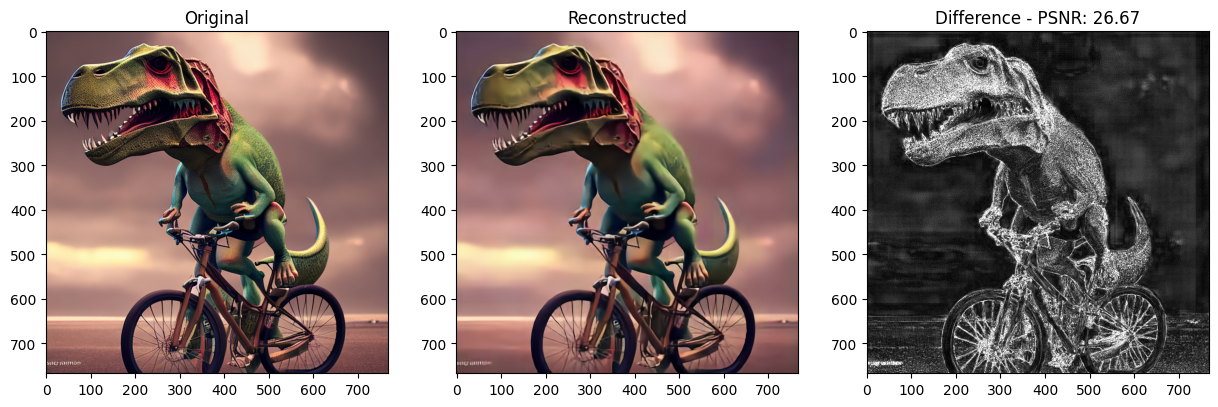

In [4]:
img = "/private/home/pfz/_images/trex_bike.png"
img = Image.open(img, "r").convert("RGB")
img_r = transforms.ToTensor()(img).unsqueeze(0).to(device)
img_r = model(img_r)
img_r = img_r['x_hat'].clamp_(0, 1)
img_r = transforms.ToPILImage()(img_r.squeeze(0))
psnr = peak_signal_noise_ratio(np.array(img), np.array(img_r))

diff = np.array(img).astype(np.float32) - np.array(img_r).astype(np.float32)
diff = np.abs(diff).astype(np.uint8)
# Y channel
diff = 0.299 * diff[:, :, 0] + 0.587 * diff[:, :, 1] + 0.114 * diff[:, :, 2]
diff = Image.fromarray( 10 * diff )

# shwo image, image recons, and difference
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[0].set_title("Original")
ax[1].imshow(img_r)
ax[1].set_title("Reconstructed")
ax[2].imshow(diff)
ax[2].set_title(f"Difference - PSNR: {psnr:.2f}")
plt.show()


In [5]:

# Set requires_grad to track gradients
x = transforms.ToTensor()(img).unsqueeze(0).to(device)
x.requires_grad = True

# Forward pass through the model
with torch.set_grad_enabled(True):
    # Make sure the model is in train mode for gradient tracking
    model.train()
    
    # Forward pass
    out = model(x)
    x_hat = out['x_hat']
    
    # Define a loss function (MSE between reconstructed image and a target)
    # Here we'll use the original image as the target for simplicity
    loss = torch.nn.functional.mse_loss(x_hat, x)
    
    # Backward pass
    loss.backward()
    
    # Check if gradient exists
    if x.grad is not None:
        print(f"Gradient exists. Gradient norm: {x.grad.norm().item():.6f}")
    else:
        print("No gradient was computed for the input.")
    
    # Reset model to eval mode
    model.eval()

Gradient exists. Gradient norm: 0.000067
